In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
df = pd.read_csv("cleaned_data.csv", low_memory=False)

# Display the first few rows
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,is_default
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
3,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
4,68426831,NaN,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0


In [65]:
#df = df[df['is_default'].notnull()]
features = ['int_rate', 'fico_range_low', 'annual_inc', 'loan_amnt', 'dti']
print(df[features].isnull().sum())


int_rate            0
fico_range_low      0
annual_inc          4
loan_amnt           0
dti               374
dtype: int64


for col in features:
    df[f'{col}_missing'] = df[col].isnull().astype(int)

This code may be used later to flag unites that have missing values before the values are mutated to add an aditional feature for pattern recognition. Maybe the missing data tells us more than if it were there. 


In [19]:
from sklearn.impute import SimpleImputer
import numpy as np

imputer = SimpleImputer(strategy='median')

X = imputer.fit_transform(df[features])
y = df['is_default'].values


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.81      0.99      0.89    323622
           1       0.50      0.06      0.10     80808

    accuracy                           0.80    404430
   macro avg       0.65      0.52      0.49    404430
weighted avg       0.74      0.80      0.73    404430

ROC AUC: 0.692173545375545


So, not too good. It is good at predicting nondefault but terrible at predicting defaults. This is most likely due to the inbalance in the class distribution.
Now I will balance the class. 

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [31]:
model = LogisticRegression(max_iter=1000)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.87      0.66      0.75    323622
           1       0.31      0.61      0.41     80808

    accuracy                           0.65    404430
   macro avg       0.59      0.64      0.58    404430
weighted avg       0.76      0.65      0.68    404430

ROC AUC: 0.6919548914393594


In [166]:
new_features = [
    'int_rate', 'fico_range_low', 'annual_inc', 'loan_amnt', 'dti', 'term', 'home_ownership']

In [168]:
print(df[new_features].isnull().sum())

int_rate            0
fico_range_low      0
annual_inc          4
loan_amnt           0
dti               374
term                0
home_ownership      0
dtype: int64


In [170]:
cat_vars = ['home_ownership']
df_encoded = pd.get_dummies(df[new_features], columns=cat_vars, drop_first=True)

In [172]:
print(df_encoded)

         int_rate  fico_range_low  annual_inc  loan_amnt    dti  term  \
0           13.99           675.0     55000.0     3600.0   5.91  36.0   
1           11.99           715.0     65000.0    24700.0  16.06  36.0   
2           10.78           695.0     63000.0    20000.0  10.78  60.0   
3           22.45           695.0    104433.0    10400.0  25.37  60.0   
4           13.44           690.0     34000.0    11950.0  10.20  36.0   
...           ...             ...         ...        ...    ...   ...   
1348094      9.49           735.0    130000.0    18000.0  20.59  60.0   
1348095     13.99           705.0    180792.0    29400.0  22.03  60.0   
1348096     14.49           735.0    157000.0    32000.0  10.34  60.0   
1348097     12.79           665.0    150000.0    16000.0  12.25  60.0   
1348098     14.49           660.0    110000.0    24000.0  18.30  60.0   

         home_ownership_MORTGAGE  home_ownership_NONE  home_ownership_OTHER  \
0                           True            

In [ ]:
df_encoded.isnull().sum().sort_values(ascending=False).head(69)


In [174]:
# For numeric columns: fill with median
df_encoded = df_encoded.fillna(df_encoded.median(numeric_only=True))


In [176]:
from sklearn.model_selection import train_test_split

X = df_encoded
y = df['is_default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


In [178]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [179]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)


Due to extended wait times I am including a progress bar and am sampling from the dataset

In [189]:
from sklearn.feature_selection import RFE

selector = RFE(estimator=LogisticRegression(), n_features_to_select=15)
X_selected = selector.fit_transform(X_resampled_scaled, y_resampled)


C:\Users\Shawn\anaconda3\Lib\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=15 > n_features=11. There will be no feature selection and all features will be kept.
  warnings.warn(


In [195]:
from tqdm import tqdm

model = LogisticRegression(max_iter=2000, solver='lbfgs')

# Enable progress tracking without restarting training at each step
with tqdm(total=1, desc="Model Training Progress", ncols=80):
    model.fit(X_resampled, y_resampled)



Model Training Progress:   0%|                            | 0/1 [00:00<?, ?it/s]C:\Users\Shawn\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Model Training Progress:   0%|                            | 0/1 [02:33<?, ?it/s]


In [197]:

#model = LogisticRegression(solver="lbfgs", max_iter=3000)
#model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85    323622
           1       0.38      0.35      0.36     80808

    accuracy                           0.75    404430
   macro avg       0.61      0.60      0.61    404430
weighted avg       0.75      0.75      0.75    404430

ROC AUC: 0.6789962780510781


TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

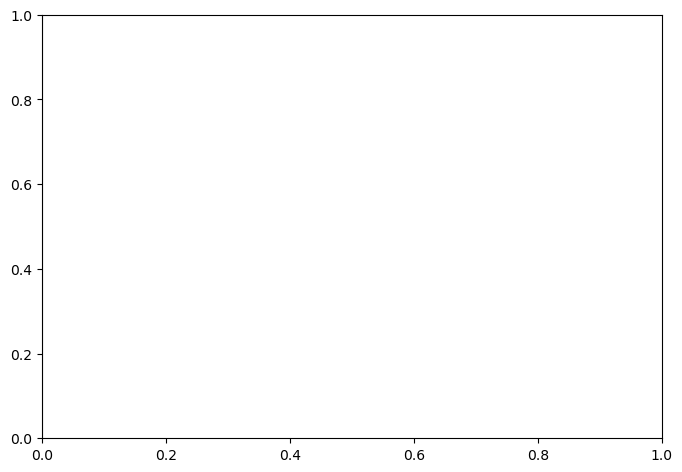

In [203]:
import shap

explainer = shap.Explainer(model, X_resampled_scaled, feature_names=X.columns)
shap_values = explainer(X_test)

# Summary plot
shap.plots.beeswarm(shap_values)